In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor

train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

sub_df = pd.read_csv("data/sample_submission.csv")
sub_df.head().T

,0,1,2,3,4
id,2190,2191,2192,2193,2194
rainfall,0,0,0,0,0


In [5]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, confusion_matrix, classification_report,
                            mean_squared_error, r2_score, brier_score_loss)
from sklearn.calibration import calibration_curve

def evaluate_binary_model(model, X_test, y_test):
    # Get predictions and probabilities
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
    
    # Classification metrics
    print("Classification Metrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
    print(f"Brier Score: {brier_score_loss(y_test, y_prob):.4f}")  # Lower is better
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Rain', 'Rain'], 
                yticklabels=['No Rain', 'Rain'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # ROC Curve
    from sklearn.metrics import RocCurveDisplay
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title('ROC Curve')
    plt.show()
    
    # Reliability diagram (calibration curve)
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Reliability Diagram')
    plt.show()
    
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_prob),
        'brier': brier_score_loss(y_test, y_prob)
    }


# Feature importance visualization
def plot_feature_importance(model, feature_names):
    # Get feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        print("Model doesn't have feature_importances_ or coef_ attributes")
        return
    
    # Sort feature importances
    indices = np.argsort(importances)[::-1]
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

In [6]:
train_df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [7]:
train_df.describe()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


In [9]:
train_df.rainfall.value_counts()

rainfall
1    1650
0     540
Name: count, dtype: int64

## Exploratory Data Analysis
- Check for missing columns/values
- Basic stats/distro.
- Correlations, Feature VIP & Engineering

From the info. output there seems to be no missing value - moving on..

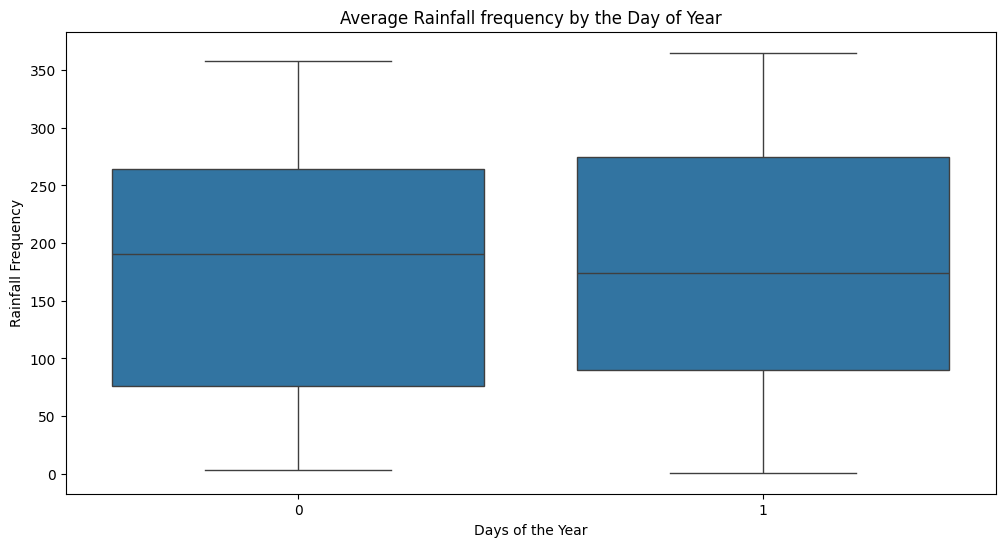

In [10]:
# Distribution of rainfall
plt.figure(figsize = (12,6))
sns.boxplot(data=train_df, x="rainfall", y="day")#, hue="alive")
plt.xlabel("Days of the Year")
plt.ylabel("Rainfall Frequency")
plt.title("Average Rainfall frequency by the Day of Year")
plt.show()

There appears to be no significant difference in the distribution of rainfall frequency between days with and without rain.

This visualization seems unusual, as typically we would expect to see a clearer difference between rainy and non-rainy days.

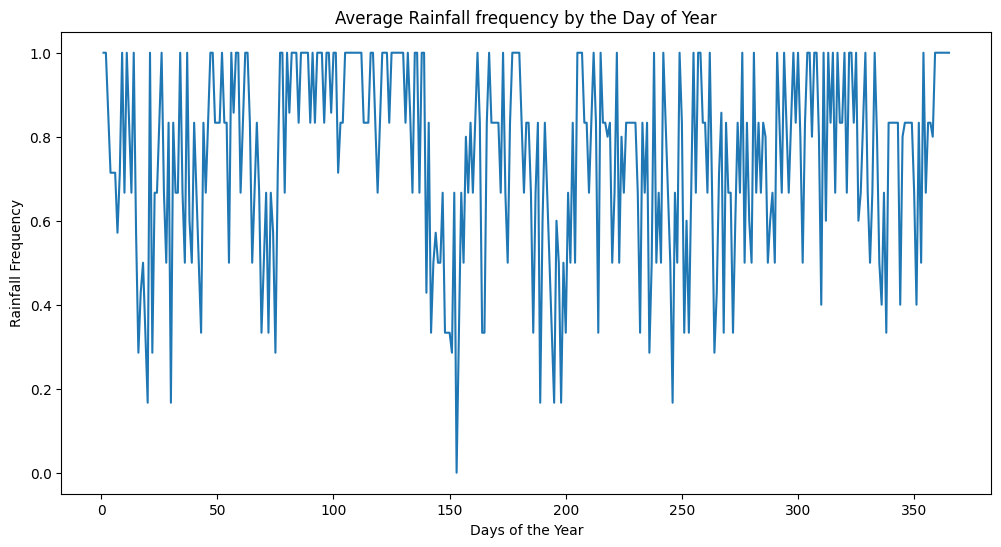

In [11]:
# Day x Rainfall
grouped_days = train_df.groupby(['day']).agg({'rainfall': 'mean'}).reset_index()

plt.figure(figsize = (12,6))
sns.lineplot(x="day", y="rainfall", data = grouped_days)
plt.xlabel("Days of the Year")
plt.ylabel("Rainfall Frequency")
plt.title("Average Rainfall frequency by the Day of Year")
plt.show()

 - The rainfall frequency appears highly variable throughout the year, with frequent fluctuations between higher and lower values.
 - Most of the year shows relatively high rainfall frequencies (between 0.6-1.0), suggesting that rain is common on many days.
 - There are notable drops in rainfall frequency at various points throughout the year. The most significant drop appears around day 150, where the frequency approaches 0, indicating a period with very little chance of rainfall.
 - Several other low points occur around days 25-50 and 175-225, which might represent drier seasons or periods.
 - The end of the year (days 300-365) shows consistently high rainfall frequency with some fluctuations, suggesting a generally wet period.


 We can still this do this for every qunlitative variable in the dataset - however, let's just check for general correlation for determine the higher influential variables.


 ##### Correlation

<Axes: >

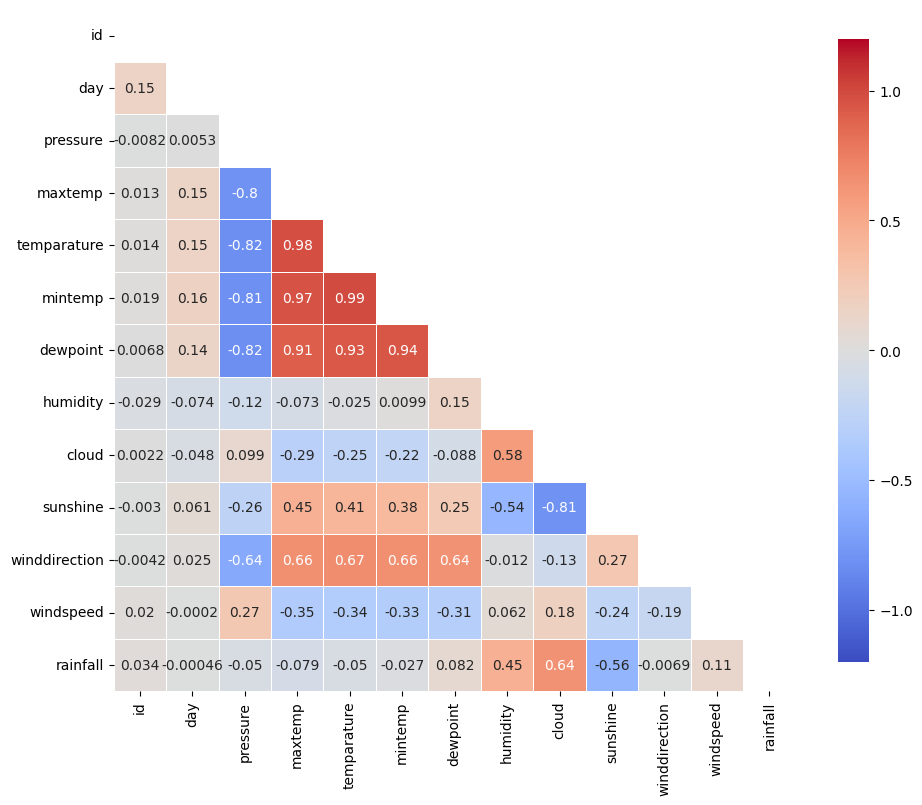

In [12]:
corr_matrix = train_df.corr()

mask = np.zeros_like(corr_matrix, dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11,9))
sns.heatmap(corr_matrix, mask = mask, center = 0,
            square = True, linewidths=.5,
            cbar_kws = {"shrink": .9}, vmin = -1.2,
            vmax = 1.2, cmap = "coolwarm", annot = True)

**Key Correlations with Rainfall:**

Strong positive correlations:

Cloud cover (0.45): More clouds correlate with higher rainfall
Sunshine (-0.56): Strong negative correlation, indicating less sunshine associates with more rain


**Weak or negligible correlations:**

Temperature variables (temperature, maxtemp, mintemp) show very weak negative correlations with rainfall
Humidity has a small positive correlation (0.082)
Wind direction and speed show minimal correlation

Here's what we are going to do - 

we will create a bunch of intermediate variables in _feature-engineering_, using the correlation here as guidance, following which we will handle redundancies and then run a _PCA_ for the VIP features for *Model Development*.

In [13]:
train_df.head().T

,0,1,2,3,4
id,0.0,1.0,2.0,3.0,4.0
day,1.0,2.0,3.0,4.0,5.0
pressure,1017.4,1019.5,1024.1,1013.4,1021.8
maxtemp,21.2,16.2,19.4,18.1,21.3
temparature,20.6,16.9,16.1,17.8,18.4
mintemp,19.9,15.8,14.6,16.9,15.2
dewpoint,19.4,15.4,9.3,16.8,9.6
humidity,87.0,95.0,75.0,95.0,52.0
cloud,88.0,91.0,47.0,95.0,45.0
sunshine,1.1,0.0,8.3,0.0,3.6


In [14]:
## Feature Engineering
df = train_df.sort_values(by = 'day').copy()

df['cloud_humidity'] = df['cloud'] * df['humidity']
df['dew_temp_diff'] = df['temparature'] - df['dewpoint']

# Temporal features
df['pressure_3d_avg'] = df['pressure'].rolling(window=3).mean()
df['humidity_7d_avg'] = df['humidity'].rolling(window=7).mean()

# Pressure Gradient
df['pressure_change'] = df['pressure'].diff()

# Cyclical features for day of year
df['temp_dewpoint_spread'] = df['temparature'] - df['dewpoint']

# Pressure change indicators
df['pressure_rising'] = (df['pressure'].diff() > 0).astype(int)
df['pressure_system'] = df['pressure'].diff().apply(
    lambda x: 'rising' if x > 0.01 else (
        'falling' if x < -0.01 else 'stable'
    )
)

## Cloud buildup rate
df['cloud_buildup'] = df['cloud'].diff()

# Threshold-based features (corrected syntax)
df['humidity_high'] = (df['humidity'] > 70).astype(int)
df['dewpoint_depression_critical'] = ((df['temparature'] - df['dewpoint']))

## Lagged variables
df['rainfall_lag1'] = df['rainfall'].shift(1)
df['pressure_lag1'] = df['pressure'].shift(1)
df['cloud_change'] = df['cloud'] - df['cloud'].shift(1)

### domain-specific indices
# Simple CAPE approximation
df['simple_cape'] = df['humidity'] * df['temp_dewpoint_spread'] * (df['temparature'] > 20).astype(int)

# Storm Potential
df['storm_index'] = (df['humidity']/100) * df['cloud'] * (1 - df['pressure']/1013.25)

In [15]:
df.head().T

,0,365,730,1460,1825
id,0,365,730,1460,1825
day,1,1,1,1,1
pressure,1017.4,1012.2,1016.8,1021.9,1013.4
maxtemp,21.2,17.1,20.5,19.3,16.2
temparature,20.6,16.1,18.1,18.1,15.2
mintemp,19.9,14.6,17.7,17.3,13.9
dewpoint,19.4,14.7,16.9,16.3,15.9
humidity,87.0,93.0,96.0,95.0,86.0
cloud,88.0,96.0,91.0,100.0,88.0
sunshine,1.1,0.2,0.0,0.0,0.0


In [16]:
df.pressure_system.value_counts()

pressure_system
rising     1077
falling    1061
stable       52
Name: count, dtype: int64

In [17]:
## Backward Fill
cols_to_fill = ['pressure_3d_avg', 'humidity_7d_avg', 'pressure_change', 'cloud_buildup', 
               'rainfall_lag1', 'pressure_lag1', 'cloud_change']

df[cols_to_fill] = df[cols_to_fill].fillna(method = 'bfill')

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18772\748738918.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[cols_to_fill] = df[cols_to_fill].fillna(method = 'bfill')


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 729
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            2190 non-null   int64  
 1   day                           2190 non-null   int64  
 2   pressure                      2190 non-null   float64
 3   maxtemp                       2190 non-null   float64
 4   temparature                   2190 non-null   float64
 5   mintemp                       2190 non-null   float64
 6   dewpoint                      2190 non-null   float64
 7   humidity                      2190 non-null   float64
 8   cloud                         2190 non-null   float64
 9   sunshine                      2190 non-null   float64
 10  winddirection                 2190 non-null   float64
 11  windspeed                     2190 non-null   float64
 12  rainfall                      2190 non-null   int64  
 13  cloud_hum

In [19]:
## Feat. Normalization

num_features = df.select_dtypes("float64").columns.to_list()
scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])

Now, let's check for Feature Importance - the VIPs

In [20]:
# a lil. more pre-processing
encoder = OneHotEncoder(sparse_output=False)

ohe = encoder.fit_transform(df[['pressure_system']])
ohd = pd.DataFrame(ohe, columns=encoder.get_feature_names_out(['pressure_system']))

df = pd.concat([df, ohd], axis = 1)
df.drop(columns = 'pressure_system', inplace = True)

In [21]:
X = df.drop(columns = "rainfall")
y = df['rainfall']

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 234)

# model
rf_model = RandomForestRegressor()
rf_model.fit(
    X_train, y_train
)

# feat. importance
importances = pd.DataFrame(
    {
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }
).sort_values('importance', ascending=False).reset_index()

importances

,index,feature,importance
0,12,cloud_humidity,0.420849
1,8,cloud,0.085464
2,9,sunshine,0.051058
3,0,id,0.037623
4,11,windspeed,0.034886
5,1,day,0.032405
6,16,pressure_change,0.028322
7,3,maxtemp,0.027269
8,15,humidity_7d_avg,0.024666
9,6,dewpoint,0.024500


Wow - did not expect that _cloud-humidity_ but it comes out on top - the combination of - *Cloud* × *Humidity*: Could capture conditions favorable for precipitation. Let's add more interacting variables.

In [22]:
df['cloud_sunshine'] = df['cloud'] * df['sunshine']
df['humidity_pressure'] = df['humidity'] * df['pressure_change']
df['cloud_pressure_change'] = df['cloud'] * df['pressure_change']
df['sunshine_humidity'] = df['sunshine'] * df['humidity']

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias = False)
top_features = ["cloud_humidity", "sunshine", "cloud", 
                "windspeed", "pressure_change",
                "pressure_lag1", "dewpoint"]

model_features = top_features + ["cloud_sunshine", "humidity_pressure"]
poly_features = poly.fit_transform(df[top_features])

c:\Users\LENOVO\Documents\tidytuesday\tidyTuesday_venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "coolsample_bytree" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\LENOVO\Documents\tidytuesday\tidyTuesday_venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "coolsample_bytree" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\LENOVO\Documents\tidytuesday\tidyTuesday_venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "coolsample_bytree" } are

Classification Metrics:
Accuracy: 0.8712
Precision: 0.9103
Recall: 0.9320
F1 Score: 0.9210
ROC AUC: 0.8616
Brier Score: 0.1016


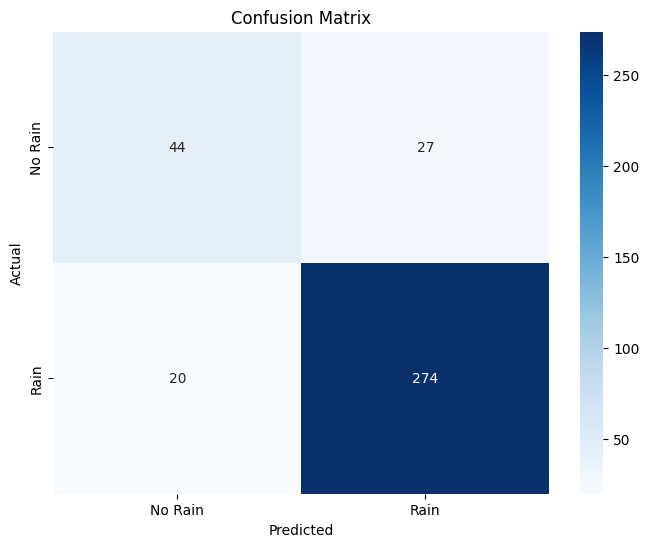


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.62      0.65        71
           1       0.91      0.93      0.92       294

    accuracy                           0.87       365
   macro avg       0.80      0.78      0.79       365
weighted avg       0.87      0.87      0.87       365



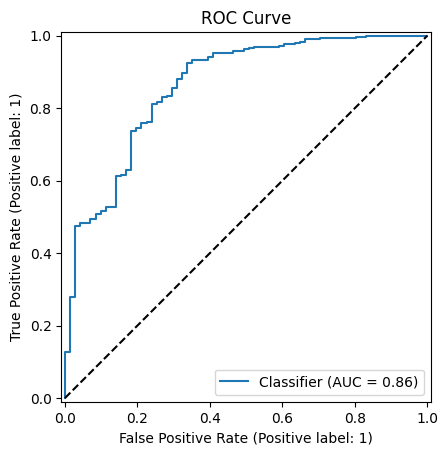

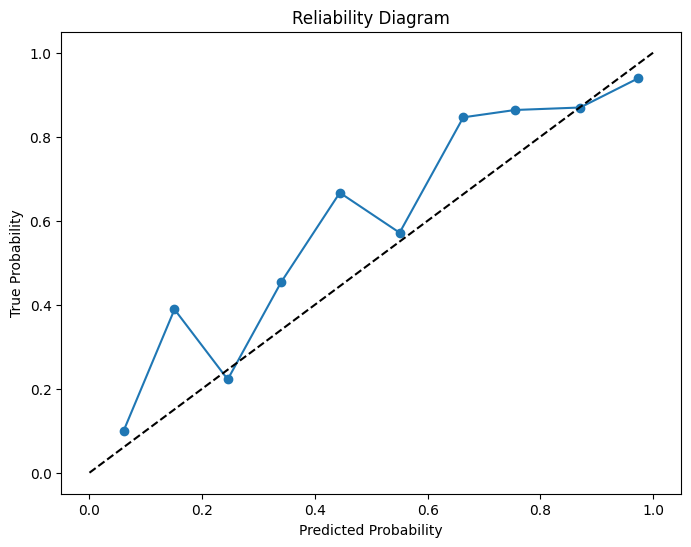

{'accuracy': 0.8712328767123287,
 'precision': 0.9102990033222591,
 'recall': 0.9319727891156463,
 'f1': 0.9210084033613445,
 'auc': np.float64(0.861646066877455),
 'brier': np.float64(0.10160839482536381)}

In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits = 5)
model = XGBClassifier(
    learning_rate = 0.05,
    n_estimators = 200,
    max_depth = 5,
    subsample=0.8,
    coolsample_bytree=0.8
)

for train_idx, test_idx in tscv.split(df[model_features]):
    X_train, X_test = df.iloc[train_idx][model_features], df.iloc[test_idx][model_features]
    y_train, y_test = df.iloc[train_idx]['rainfall'], df.iloc[test_idx]['rainfall']
    model.fit(X_train, y_train)
    
evaluate_binary_model(model, X_test, y_test)
    

 - Accuracy (0.8658): This indicates that 86.58% of the predictions made the model are correct. It's a general measure of how often the model is right.
 - Precision (0.9125): This tells you that when the model predicts a positive class, it is correct 91.25% of the time. Precision is important when the cost of false positives is high.
 - Recall (0.9218): This means that the model correctly identifies 92.18% of all actual positive cases. Recall is crucial when the cost of false negatives is high.
 - F1 Score (0.9171): This is the harmonic mean of precision and recall, providing a balance between the two. An F1 score of 0.9171 indicates a good balance between precision and recall.
 - ROC AUC (0.8638): The ROC AUC score of 0.8638 shows that the model has a good ability to distinguish between the positive and negative classes. A score closer to 1 indicates better performance.
 - Brier Score (0.1030): This measures the accuracy of probabilistic predictions. A lower Brier score indicates better calibrated predictions. A score of 0.1030 suggests that the model's probability estimates are quite accurate.

 Now - let's validate with the actual test records..

In [46]:
test_ids = train_df['id'].copy
test_features = test_df.drop(columns=['id'])

In [48]:
## Validate Model
# feat. engineering function

def feat_eng(df: pd.DataFrame):
    df = df.sort_values(by = 'day').copy()

    df['cloud_humidity'] = df['cloud'] * df['humidity']
    df['dew_temp_diff'] = df['temparature'] - df['dewpoint']

    # Temporal features
    df['pressure_3d_avg'] = df['pressure'].rolling(window=3).mean()
    df['humidity_7d_avg'] = df['humidity'].rolling(window=7).mean()

    # Pressure Gradient
    df['pressure_change'] = df['pressure'].diff()

    # Cyclical features for day of year
    df['temp_dewpoint_spread'] = df['temparature'] - df['dewpoint']

    # Pressure change indicators
    df['pressure_rising'] = (df['pressure'].diff() > 0).astype(int)
    df['pressure_system'] = df['pressure'].diff().apply(
        lambda x: 'rising' if x > 0.01 else (
            'falling' if x < -0.01 else 'stable'
        )
    )

    ## Cloud buildup rate
    df['cloud_buildup'] = df['cloud'].diff()

    # Threshold-based features (corrected syntax)
    df['humidity_high'] = (df['humidity'] > 70).astype(int)
    df['dewpoint_depression_critical'] = ((df['temparature'] - df['dewpoint']))

    ## Lagged variables
    # df['rainfall_lag1'] = df['rainfall'].shift(1)
    df['pressure_lag1'] = df['pressure'].shift(1)
    df['cloud_change'] = df['cloud'] - df['cloud'].shift(1)

    ### domain-specific indices
    # Simple CAPE approximation
    df['simple_cape'] = df['humidity'] * df['temp_dewpoint_spread'] * (df['temparature'] > 20).astype(int)

    # Storm Potential
    df['storm_index'] = (df['humidity']/100) * df['cloud'] * (1 - df['pressure']/1013.25)

    cols_to_fill = ['pressure_3d_avg', 'humidity_7d_avg', 'pressure_change', 'cloud_buildup', 
               'pressure_lag1', 'cloud_change']

    df[cols_to_fill] = df[cols_to_fill].fillna(method = 'bfill')

    num_features = df.select_dtypes("float64").columns.to_list()
    scaler = StandardScaler()
    df[num_features] = scaler.fit_transform(df[num_features])

    encoder = OneHotEncoder(sparse_output=False)

    ohe = encoder.fit_transform(df[['pressure_system']])
    ohd = pd.DataFrame(ohe, columns=encoder.get_feature_names_out(['pressure_system']))

    df = pd.concat([df, ohd], axis = 1)
    df.drop(columns = 'pressure_system', inplace = True)

    # model features
    df['cloud_sunshine'] = df['cloud'] * df['sunshine']
    df['humidity_pressure'] = df['humidity'] * df['pressure_change']
    df['cloud_pressure_change'] = df['cloud'] * df['pressure_change']
    df['sunshine_humidity'] = df['sunshine'] * df['humidity']

    poly = PolynomialFeatures(2, include_bias = False)
    top_features = ["cloud_humidity", "sunshine", "cloud", 
                    "windspeed", "pressure_change",
                    "pressure_lag1", "dewpoint"]

    model_features = top_features + ["cloud_sunshine", "humidity_pressure"]
    poly_features = poly.fit_transform(df[top_features])

    return df, top_features, model_features, poly_features

df_test, top_f, model_f, poly_f = feat_eng(test_df)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_18772\291876661.py:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[cols_to_fill] = df[cols_to_fill].fillna(method = 'bfill')


In [ ]:
# #  Ensure alignment
# if len(df_test) != len(test_df):
#     print(f"Transformed Shape: {len(df_test)}", "\n")
#     print(f"Original Shape: {len(test_df)}", "\n")
#     raise ValueError("Processed test data has a "
#     "different number of rows than the original")

assert len(df_test) == len(test_features), "Row count mismatch after processing"

In [61]:
test_X = df_test[model_f]

predictions = model.predict(test_X)
y_proba = model.predict_proba(test_X)[:, 1]

# 1. Check dimensions
print(f"Original test_df shape: {test_df.shape}")
print(f"Processed df_test shape: {df_test.shape}")
print(f"Predictions shape: {predictions.shape}")
print(f"Number of IDs: {len(test_df['id'])}")

# 2. Create a submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'].values,
    'rainfall': predictions
})

# 3. Verify submission_df
print(f"Submissio shape: {submission_df.shape}")
print(submission_df.head())

# 6. Save submission
submission_df.to_csv('submission.csv', index=False)
print("\nCreated Submission File")

Original test_df shape: (730, 12)
Processed df_test shape: (730, 33)
Predictions shape: (730,)
Number of IDs: 730
Submissio shape: (730, 2)
     id  rainfall
0  2190         1
1  2191         1
2  2192         1
3  2193         1
4  2194         1

Created Submission File
